# Bedrock Models Tuturial

1. [Model](#model)
    - [Quickstart from Titan Embedding](#quickstart-from-titan-embedding)
    - [Amazon Titan Large](#amazon-titan-large)
    - [Anthropic Claude](#anthropic-claude-streaming)
    - [Amazon Jurassic Grande](#ai21-jurassic-grande)
    - [Stability Stable Diffusion XL](#stability-stable-diffusion-xl)
2. [Application](#application)
    - [Use Langchain with Claude v1](#use-langchain-with-claude-v1)
    - [Use Langchain with template](#use-langchain-with-template)
    - [Use Langchain for large file](#use-langchain-for-large-file)
    - [RAG with Bedrock](#rag-with-bedrock)
    - [Chatbot (multi-conversation), not question answering](#chatbot-multi-conversation-not-question-answering)

# Model

## Quickstart from Titan Embedding

In [ ]:
!pwd
!python3 -m pip install ./boto3-1.28.21-py3-none-any.whl
!python3 -m pip install ./botocore-1.31.21-py3-none-any.whl

In [2]:
import boto3
import json
# specify the profile to call the bedrock api
session = boto3.Session(profile_name='bedrock')
bedrock = session.client(
 service_name='bedrock',
 region_name='us-east-1',
 endpoint_url='https://bedrock.us-east-1.amazonaws.com'
)

In [8]:
bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': '18776f7a-6fbf-4ad7-be52-3019443ca911',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 09 Aug 2023 14:42:03 GMT',
   'content-type': 'application/json',
   'content-length': '972',
   'connection': 'keep-alive',
   'x-amzn-requestid': '18776f7a-6fbf-4ad7-be52-3019443ca911'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large'},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-e1t-medium',
   'modelId': 'amazon.titan-e1t-medium'},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/stability.stable-diffusion-xl',
   'modelId': 'stability.stable-diffusion-xl'},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/ai21.j2-grande-instruct',
   'modelId': 'ai21.j2-grande-instruct'},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/ai21.j2-jumbo-instruct',
   'modelId': 'ai21.j2-jumbo-in

In [9]:
# We will be using the Titan Embeddings Model to generate our Embeddings.

def get_embedding(body, modelId, accept, contentType):
    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

body = json.dumps({"inputText": "explain black holes to 8th graders"})
modelId = 'amazon.titan-e1t-medium'
accept = 'application/json'
contentType = 'application/json'

embedding = get_embedding(body, modelId, accept, contentType)
print(embedding)

[0.5625, 0.53515625, 0.046875, 0.18457031, 0.17382812, -0.0010681152, 0.33789062, -0.039794922, -0.20507812, -0.31640625, -0.38085938, 0.13574219, 0.36132812, -0.32421875, 0.087402344, 0.28515625, -0.07763672, -0.084472656, -0.546875, -0.5703125, -0.39648438, 0.4921875, -0.3984375, 0.20703125, -0.8203125, 0.07714844, -0.13476562, -0.515625, -0.43945312, 0.31054688, 0.05419922, 0.07373047, 0.18066406, -0.35742188, -0.011352539, 0.53125, -0.04296875, -0.5625, -0.34765625, -0.14257812, 0.68359375, -0.07373047, -0.13574219, -0.43945312, 0.31054688, 0.38867188, 0.21679688, 0.14160156, -0.103027344, -0.083496094, -0.29296875, -0.13183594, 0.13085938, 0.43554688, -0.43359375, -0.171875, -0.4140625, 0.67578125, 0.012268066, 0.115722656, 0.28710938, -0.10546875, -0.059814453, 0.42382812, 0.2578125, 0.36523438, 0.064453125, 0.3671875, -0.49414062, 0.078125, -0.09326172, -0.17773438, -0.48828125, 0.11621094, -0.20800781, 0.10205078, 0.060791016, -0.095703125, 0.31054688, 0.45703125, -0.41992188, 

A use case of sentence embedding is to cluster together sentences with similar semantic meaning.  In the example below we compute the embeddings of sentences in three categories: pets, cities in the U.S., and color.  We see that sentences originating from the same category have much closer embedding vectors than those from different categories.  Specifically, the code will do the following:
The Bedrock embedding API will output an embedding vector for each sentence;  The distance between any pair of sentences is computed by the cosine similarity of corresponded embedding vectors;A heatmap is created to visualize the distance between any pair of sentences in the embedding space. Darker the color, larger the cosine similarity (smaller the distance).
Note. Cosine similarity of two vectors is  the inner product of the normalized vectors (scale down to have length 1).

In [ ]:
!pip install scikit-learn
!pip install seaborn

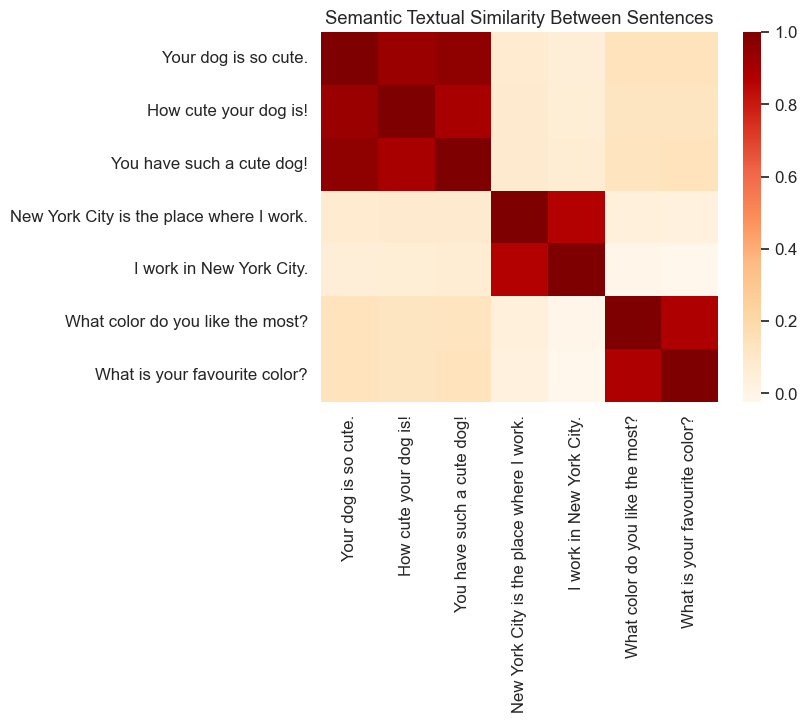

In [17]:
import sklearn
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns


def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


sentences = [
    # Pets
    "Your dog is so cute.",
    "How cute your dog is!",
    "You have such a cute dog!",
    # Cities in the US
    "New York City is the place where I work.",
    "I work in New York City.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

embeddings = []

for sentence in sentences:
    sentence = json.dumps({"inputText": sentence})
    query_response = get_embedding(body=sentence, modelId='amazon.titan-e1t-medium', accept='application/json', contentType='application/json')
    embeddings.append(query_response)
    
embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product
plot_similarity_heatmap(sentences, embeddings, 90)

## Amazon Titan Large

In [18]:
!pip install --quiet langchain==0.0.249

In [49]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Command: Write me a blog about making strong business decisions as a leader.

Blog:
"""

In [50]:
body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-tg1-large"
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("results")[0].get("outputText"))

As a leader, making strong business decisions is crucial to the success of your organization. The decisions you make can impact the morale of your employees, the growth of the company, and its overall success. Here are some tips to help you make strong business decisions:

Gather information: Before making a decision, it is important to gather as much information as possible. This includes researching the problem, talking to stakeholders, and gathering feedback from your team. Make sure you have a clear understanding of the situation before making a decision.

Consider multiple options: Don't make a decision based on the first solution that comes to mind. Consider


## Anthropic Claude (Streaming)

In [51]:
body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completion"))

As a leader, making strong business decisions is critical for a company's success. Here are four tips for making strong choices that propel your organization forward:

1) Think strategically. Before making any decision, consider how it fits into your company's overall strategy and long-term goals. Will it help advance your strategic priorities or detract from them? Look for alignments that boost broader plans and directions.   

2) Use data and facts, not just gut instinct. Gather relevant information, look at past trends and performance indicators, and run comparisons and projections using budget numbers. Make decisions based on the clearest picture you can get, not just subjective opinions.  

3) Consider multiple alternatives. Typically there are several options to choose from when making business decisions. Evaluate the pros and cons of at least 3-4 viable alternatives before settling on one. Thoroughly scrutinize each option to find the best available choice.
  
4) Be comfortable 

In [52]:
response = bedrock.invoke_model_with_response_stream(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
stream = response.get('body')
output = list(stream)
output

[{'chunk': {'bytes': b'{"completion":"As","stop_reason":null}'}},
 {'chunk': {'bytes': b'{"completion":" a leader, you will frequently be called upon to make tough but important business decisions. Here are","stop_reason":null}'}},
 {'chunk': {'bytes': b'{"completion":" some tips to help you make strong decisions that will move your organization forward:\\n\\n1) Look at the","stop_reason":null}'}},
 {'chunk': {'bytes': b'{"completion":" big picture. Rather than focusing on short-term gains, evaluate how your decision will impact the overall strategy, goals","stop_reason":null}'}},
 {'chunk': {'bytes': b'{"completion":", and mission of the organization. Short-cuts and quick fixes may appear tempting, but make sure they align","stop_reason":null}'}},
 {'chunk': {'bytes': b'{"completion":" with the organization\'s long-term vision. \\n\\n2) Gather multiple perspectives. Solicit input from people in","stop_reason":null}'}},
 {'chunk': {'bytes': b'{"completion":" different roles and departm

In [54]:
from IPython.display import display_markdown,Markdown,clear_output
response = bedrock.invoke_model_with_response_stream(body=body, modelId=modelId, accept=accept, contentType=contentType)
stream = response.get('body')
output = []
i = 1
if stream:
    for event in stream:
        chunk = event.get('chunk')
        if chunk:
            chunk_obj = json.loads(chunk.get('bytes').decode())
            text = chunk_obj['completion']
            clear_output(wait=True)
            output.append(text)
            display_markdown(Markdown(''.join(output)))
            i+=1

As a leader, you often have to make difficult business decisions that impact your team, organization, and bottom line. Here are some tips for making strong decisions that move your business forward:

1. Gather all relevant facts and data. Don't make decisions based on limited or biased information. Take the time to obtain objective facts and data from reliable sources. Look at trends, projections, impact on budgets and metrics. Examine the decision from multiple angles.  

2. Consider possible alternatives and consequences. Don't focus on the first option that comes to mind. Think of 2-3 other possible choices and weigh their pros and cons. Evaluate the short-term and long-term impact of each option. 

3.Involve the right people. Get input from those who will be impacted by the decision as well as subject matter experts. Their perspectives can highlight considerations you may have missed. But make it clear that you'll make the final call.

4. Trust your instincts, within reason. Don't ignore data, but don't dismiss your gut feelings completely. A combination of rational analysis and intuition often leads to the strongest decisions. Just be aware of any possible biases.

5. Make timely decisions. Avoid paralysis by overanalysis. Gather sufficient information to make an informed decision, then act before the opportunity passes. You can course correct later if needed. Most leaders would rather make a timely wrong decision than no decision at all.

6. Communicate your decision clearly and confidently. Explain the rationale to those impacted in a transparent manner. State what actions they need to take to implement the decision, and establish next steps and follow up. Your confidence and conviction will help gain buy-in. 

7. Follow through and review. Once a decision is made, provide the resources and support needed for execution. Then monitor progress and results. Revisit the decision periodically to determine if an adjustment or change of course is warranted.

In the end, making strong business decisions as a leader comes down to balancing thoroughness, urgency, and conviction. With the right processes and mindset, you can make choices that move your business in the direction you want it to go.

## AI21 Jurassic Grande

In [24]:
body = json.dumps({"prompt": prompt_data, "maxTokens": 200})
modelId = "ai21.j2-grande-instruct"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completions")[0].get("data").get("text"))

Decision Making is the Heart of any leader!

Strong decision making was not born and it was not developed! A strong leader must be a decision-maker at any time and on any occasion!

Strong decision-making means making good decisions in a correct way and with the necessary wisdom, benefit, and efficiency!

Strong leadership means first, understanding the company situation, its development and its future perspective!

It means that the leader must have the ability to assess the company's capabilities and the opportunities that it offers to the leader!

This means that the first criterion for a leader's decision making is him/her understanding the field and the nature of his company!

Therefore, the essence of leader's decision making is the leader's understanding!

Thus, a leader without a good decision isn't a leader! 

Finally, I should reiterate that I can't talk about all the above topics I also need your help


## Stability Stable Diffusion XL

In [26]:
prompt_data = "a fine image of an astronaut riding a horse on Mars"
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl"
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAABrGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


In [29]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image.show()

In [34]:
# Streaming output
from IPython.display import clear_output, display, display_markdown, Markdown

body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-tg1-large"  # (Change this, and the request body, to try different models)
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model_with_response_stream(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
stream = response.get('body')
output = []

if stream:
    for event in stream:
        chunk = event.get('chunk')
        if chunk:
            chunk_obj = json.loads(chunk.get('bytes').decode())
            text = chunk_obj['outputText']
            clear_output(wait=True)
            output.append(text)
            display_markdown(Markdown(''.join(output)))


An astronaut is riding a horse on the red planet Mars, which appears to be a desert landscape with rocky outcrops and sand dunes in the distance.

In [35]:
# Again, embedding with Titan
prompt_data = "Amazon Bedrock supports foundation models from industry-leading providers such as \
AI21 Labs, Anthropic, Stability AI, and Amazon. Choose the model that is best suited to achieving \
your unique goals."

body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-e1t-medium"  # (Change this to try different embedding models)
accept = "application/json"
contentType = "application/json"

response = bedrock.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

embedding = response_body.get("embedding")
print(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

The embedding vector has 4096 values
[-0.026367188, 0.14160156, -0.119140625, '...', -0.01940918, 0.23632812, -0.12597656]


# Application

## Use Langchain with claude-v1

In [ ]:
'''
Available text generation models under Amazon Bedrock have the following IDs:

- amazon.titan-tg1-large
- ai21.j2-grande-instruct
- ai21.j2-jumbo-instruct
- anthropic.claude-instant-v1
- anthropic.claude-v1
'''

In [ ]:
# Helper function
from io import StringIO
import sys
import textwrap
def print_ww(*args, width: int = 100, **kwargs):
    """Like print(), but wraps output to `width` characters (default 100)"""
    buffer = StringIO()
    try:
        _stdout = sys.stdout
        sys.stdout = buffer
        print(*args, **kwargs)
        output = buffer.getvalue()
    finally:
        sys.stdout = _stdout
    for line in output.splitlines():
        print("\n".join(textwrap.wrap(line, width=width)))

In [36]:
from langchain.llms.bedrock import Bedrock

inference_modifier_claude = {
    # "prompt": "\n\nHuman:<prompt>\n\nAnswer:",
    "max_tokens_to_sample": 4096,
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman"],
}

inference_modifier_titan = {
    "maxTokenCount": 512,
    "stopSequences": [],
    "temperature": 0.1,  
    "topP": 0.9,
}

textgen_llm = Bedrock(
    # model_id="anthropic.claude-v1",
    model_id="amazon.titan-tg1-large",
    client=bedrock,
    # model_kwargs=inference_modifier_claude,
    model_kwargs=inference_modifier_titan,
)

In [37]:
response = textgen_llm("""Write an email from Bob, Customer Service Manager, 
to the customer "John Doe" that provided negative feedback on the service 
provided by our customer support engineer.\n\nHuman:""")

print_ww(response)

 John

Subject: Apologies for the inconvenience

Dear John,

Thank you for bringing the issues with our customer service to my attention. I'm sorry that you had
a bad experience when you called our customer service number recently. We aim to give the best
service possible, and it's clear that we fell short in this case.

Please know that we take your feedback seriously, and we're working to make sure this doesn't happen
again. Our team is investigating the issue to prevent it from happening in the future.

In the meantime, I'd like to offer you a refund or credit for the inconvenience this has caused. How
would you like to proceed?

Thank you for your patience and understanding.

Best regards,
Bob
Customer Service Manager.


## Use Langchain with template

In [38]:
!pip install --quiet  "transformers>=4.24,<5"

In [40]:
from langchain.llms.bedrock import Bedrock

inference_modifier = {'max_tokens_to_sample':4096, 
                      "temperature":0.5,
                      "top_k":250,
                      "top_p":1,
                      "stop_sequences": ["\n\nHuman"]
                     }

textgen_llm = Bedrock(model_id = "anthropic.claude-v1",
                    client = bedrock, 
                    model_kwargs = inference_modifier 
                    )


In [39]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
multi_var_prompt = PromptTemplate(
    input_variables=["customerServiceManager", "customerName", "feedbackFromCustomer"], 
    template="""Create an apology email from the Service Manager {customerServiceManager} to {customerName}. 
   in response to the following feedback that was received from the customer: {feedbackFromCustomer}.
   """
)

# Pass in values to the input variables
prompt = multi_var_prompt.format(customerServiceManager="Bob", 
                                 customerName="John Doe", 
                                 feedbackFromCustomer="""Hello Bob,
     I am very disappointed with the recent experience I had when I called your customer support.
     I was expecting an immediate call back but it took three days for us to get a call back.
     The first suggestion to fix the problem was incorrect. Ultimately the problem was fixed after three days.
     We are very unhappy with the response provided and may consider taking our business elsewhere.
     """
     )


In [ ]:
num_tokens = textgen_llm.get_num_tokens(prompt)
print(f"Our prompt has {num_tokens} tokens")

In [46]:
response = textgen_llm(prompt)
print(response)
email = response[response.index('\n')+1:]
print_ww(email)


Here is a draft of the apology email:

Dear John,

I want to sincerely apologize for the poor experience you had with our customer support team recently. We clearly failed to meet your expectations and provide the level of service you deserve as a valued customer. 

There is no excuse for the delayed response and incorrect information you received. I take full responsibility for this failure and will work to ensure this does not happen again. Your business and satisfaction are extremely important to us.

To make things right, I would like to offer you a credit for the amount of your last invoice. Please let me know if there's anything else I can do to restore your confidence in our company and the service we provide. 

We appreciate your patience and understanding. I hope we can continue our working relationship, as we highly value your business. If there's any way I can be of further assistance, please don't hesitate to contact me directly.

Again, please accept my apologies. We will

## Use Langchain for large file

In [55]:
from langchain.llms.bedrock import Bedrock

llm = Bedrock(
    model_id="amazon.titan-tg1-large",
    model_kwargs={
        "maxTokenCount": ,
        "stopSequences": [],
        "temperature": 0,
        "topP": 1,
    },
    client=bedrock,
)

In [69]:
shareholder_letter = "./letter.txt"

with open(shareholder_letter, "r") as file:
    letter = file.read()
    
llm.get_num_tokens(letter)

Token indices sequence length is longer than the specified maximum sequence length for this model (6526 > 1024). Running this sequence through the model will result in indexing errors


6526

In [73]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n"], chunk_size=4000, chunk_overlap=100
)

docs = text_splitter.create_documents([letter])

num_docs = len(docs)
i = 0
token_count = 0
# iterate all documents and print the number of tokens per page
for doc in docs:
    i += 1
    num_tokens = llm.get_num_tokens(doc.page_content)
    print(f"This document has {num_tokens} tokens in page {i}")
    token_count += num_tokens
print("This document has {} tokens in total".format(token_count))

This document has 439 tokens in page 1
This document has 677 tokens in page 2
This document has 619 tokens in page 3
This document has 795 tokens in page 4
This document has 738 tokens in page 5
This document has 790 tokens in page 6
This document has 600 tokens in page 7
This document has 701 tokens in page 8
This document has 394 tokens in page 9
This document has 755 tokens in page 10
This document has 6508 tokens in total


LangChain's [load_summarize_chain](https://python.langchain.com/en/latest/use_cases/summarization.html) to summarize the text. `load_summarize_chain` provides three ways of summarization: `stuff`, `map_reduce`, and `refine`. 
- `stuff` puts all the chunks into one prompt. Thus, this would hit the maximum limit of tokens.
- `map_reduce` summarizes each chunk, combines the summary, and summarizes the combined summary. If the combined summary is too large, it would raise error.
- `refine` summarizes the first chunk, and then summarizes the second chunk with the first summary. The same process repeats until all chunks are summarized.

`map_reduce` and `refine` invoke LLM multiple times and takes time for obtaining final summary. 

In [76]:
# Set verbose=True if you want to see the prompts being used
from langchain.chains.summarize import load_summarize_chain
summary_chain = load_summarize_chain(llm=llm, chain_type="refine", verbose=False)

output = summary_chain.run(docs)

In [77]:
print_ww(output.strip())

Jeff Bezos, the CEO of Amazon, writes a letter to shareholders, highlighting the company's
achievements and challenges in 2022. Despite a difficult macroeconomic environment, Amazon was able
to increase demand and innovate in its core businesses. Bezos emphasizes the company's long-term
investments and its ability to adapt to constant change in the market. He also mentions the progress
made in sustainability and social responsibility, such as reducing carbon emissions and providing
support to small businesses. Bezos acknowledges the challenges the company faces, such as the
ongoing COVID-19 pandemic and competition in the tech industry, but remains optimistic about
Amazon's future.

The most important details in this text are the challenges that Amazon has faced throughout its
history, such as the 2001 dot-com crash and the 2008–2009 recession. Despite these challenges,
Amazon has been able to adapt and innovate, and this has allowed it to become a successful company
with a strong futu

## RAG with Bedrock

Core components as follows:

- **LLM (Large Language Model)**: Anthropic Claude V1 available through Amazon Bedrock

  This model will be used to understand the document chunks and provide an answer in human friendly manner.
- **Embeddings Model**: Amazon Titan Embeddings available through Amazon Bedrock

  This model will be used to generate a numerical representation of the textual documents
- **Document Loader**: PDF Loader available through LangChain

  This is the loader that can load the documents from a source, for the sake of this notebook we are loading the sample files from a local path. This could easily be replaced with a loader to load documents from enterprise internal systems.

- **Vector Store**: FAISS available through LangChain

  In this notebook we are using this in-memory vector-store to store both the embeddings and the documents. In an enterprise context this could be replaced with a persistent store such as AWS OpenSearch, RDS Postgres with pgVector, ChromaDB, Pinecone or Weaviate.
- **Index**: VectorIndex

  The index helps to compare the input embedding and the document embeddings to find relevant document
- **Wrapper**: wraps index, vector store, embeddings model and the LLM to abstract away the logic from the user.

In [78]:
!pip install --quiet "faiss-cpu>=1.7,<2" langchain==0.0.249 "pypdf>=3.8,<4"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
# We will be using the Titan Embeddings Model to generate our Embeddings.
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

# - create the Anthropic Model
llm = Bedrock(model_id="anthropic.claude-v1", client=bedrock, model_kwargs={'max_tokens_to_sample':200})
# use Titan implicitly with default value model_id: str = "amazon.titan-e1t-medium"
bedrock_embeddings = BedrockEmbeddings(client=bedrock)

In [81]:
from urllib.request import urlretrieve
import os

os.makedirs("data", exist_ok=True)
files = [
    "https://www.irs.gov/pub/irs-pdf/p1544.pdf",
    "https://www.irs.gov/pub/irs-pdf/p15.pdf",
    "https://www.irs.gov/pub/irs-pdf/p1212.pdf",
]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)

In [82]:
import numpy as np
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("./data/")

documents = loader.load()
# - in our testing Character split works better with this PDF data set
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 100,
)
docs = text_splitter.split_documents(documents)

In [83]:
avg_doc_length = lambda documents: sum([len(doc.page_content) for doc in documents])//len(documents)
avg_char_count_pre = avg_doc_length(documents)
avg_char_count_post = avg_doc_length(docs)
print(f'Average length among {len(documents)} documents loaded is {avg_char_count_pre} characters.')
print(f'After the split we have {len(docs)} documents more than the original {len(documents)}.')
print(f'Average length among {len(docs)} documents (after split) is {avg_char_count_post} characters.')

Average length among 73 documents loaded is 5844 characters.
After the split we have 503 documents more than the original 73.
Average length among 503 documents (after split) is 909 characters.


In [84]:
sample_embedding = np.array(bedrock_embeddings.embed_query(docs[0].page_content))
print("Sample embedding of a document chunk: ", sample_embedding)
print("Size of the embedding: ", sample_embedding.shape)

Sample embedding of a document chunk:  [-0.15917969  0.76171875  0.24511719 ...  0.12109375 -0.25585938
  0.06591797]
Size of the embedding:  (4096,)


In [85]:
from langchain.chains.question_answering import load_qa_chain
from langchain.vectorstores import FAISS
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

vectorstore_faiss = FAISS.from_documents(
    docs,
    bedrock_embeddings,
)

wrapper_store_faiss = VectorStoreIndexWrapper(vectorstore=vectorstore_faiss)

In [96]:
query = "Is it possible that I get sentenced to jail due to failure in filings?"
query_embedding = vectorstore_faiss.embedding_function(query)
np.array(query_embedding)

array([-0.11181641, -0.20019531,  0.00915527, ..., -0.4921875 ,
       -0.05664062,  0.43359375])

In [97]:
relevant_documents = vectorstore_faiss.similarity_search_by_vector(query_embedding)
print(f'{len(relevant_documents)} documents are fetched which are relevant to the query.')
print('----')
for i, rel_doc in enumerate(relevant_documents):
    print_ww(f'## Document {i+1}: {rel_doc.page_content}.......')
    print('---')

4 documents are fetched which are relevant to the query.
----
## Document 1: There are civil penalties for failure to:
File a correct Form 8300 by the date it is
due, and
Provide the required statement to those
named in the Form 8300.
If you intentionally disregard the requirement
to file a correct Form 8300 by the date it is due,
the penalty is the greater of:
1.$25,000, or
2.The amount of cash you received and
were required to report (up to $100,000).
There are criminal penalties for:
Willful failure to file Form 8300,
Willfully filing a false or fraudulent Form
8300,
Stopping or trying to stop Form 8300 from
being filed, and
Setting up, helping to set up, or trying to
set up a transaction in a way that would
make it seem unnecessary to file Form
8300.
If you willfully fail to file Form 8300, you can
be fined up to $250,000 for individuals
RECORDS($500,000 for corporations) or sentenced to up
to 5 years in prison, or both. These dollar
amounts are based on Section 3571 of Title 18
of

In [98]:
answer = wrapper_store_faiss.query(question=query, llm=llm)
print_ww('answer from faiss query without sources {}'.format(answer))

answer = wrapper_store_faiss.query_with_sources(question=query, llm=llm)
print_ww('answer from faiss query with sources {}'.format(answer))

answer from faiss query without sources  Yes, it is possible to face jail time for willful failure
to file Form 8300. According to the context provided:

"There are criminal penalties for:
Willful failure to file Form 8300,
...
If you willfully fail to file Form 8300, you can
be fined up to $250,000 for individuals ($500,000 for corporations) or sentenced to up to 5 years in
prison, or both."

So if you intentionally and knowingly fail to file Form 8300 when required, you could face up to 5
years in prison, in addition to large fines.
answer from faiss query with sources {'question': 'Is it possible that I get sentenced to jail due
to failure in filings?', 'answer': ' Yes, it is possible to get sentenced to jail for failure in
filings. The penalties for failure to file Form 8300 include civil and criminal penalties. Civil
penalties include fines up to $100,000. Criminal penalties include fines up to $250,000 and up to 5
years of imprisonment. \n', 'sources': 'data/p1544.pdf\n\nQUESTION

In [101]:
query_2 = "What is the difference between market discount and qualified stated interest"

answer_2 = wrapper_store_faiss.query(question=query_2, llm=llm)
print_ww('answer from faiss query without sources {}'.format(answer_2))

answer_2 = wrapper_store_faiss.query_with_sources(question=query_2, llm=llm)
print_ww('answer from faiss query without sources {}'.format(answer_2))


answer from faiss query without sources  Based on the context provided:

Market discount refers to the difference between the issue price plus accrued OID of a debt
instrument, and the adjusted basis (usually the purchase price) of the debt instrument immediately
after you acquire it. It occurs when the value of the debt instrument has decreased since it was
originally issued.

Qualified stated interest refers to interest that is unconditionally payable in cash or property at
least annually over the term of the debt instrument at a fixed rate. It is different from market
discount.

So in summary:

- Market discount refers to a decrease in value/price of a debt instrument.
- Qualified stated interest refers to fixed interest payments made on a debt instrument.

They are two separate concepts. Does this help explain the difference?
answer from faiss query without sources {'question': 'What is the difference between market discount
and qualified stated interest', 'answer': ' The key diffe

In [102]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

prompt_template = """Human: Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Assistant:"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)
# chain_type: Type of document combining chain to use. Should be one of "stuff", "map_reduce", "map_rerank", and "refine".
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss.as_retriever(
        search_type="similarity", search_kwargs={"k": 3}
    ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
query = "Is it possible that I get sentenced to jail due to failure in filings?"
result = qa({"query": query})
print_ww(result['result'])

 Yes, it is possible to be sentenced to jail for willful failure to file certain tax forms, like
Form 8300. According to the context provided:

"There are criminal penalties for:
Willful failure to file Form 8300,
Willfully filing a false or fraudulent Form
8300,
Stopping or trying to stop Form 8300 from
being filed, and
Setting up, helping to set up, or trying to
set up a transaction in a way that would
make it seem unnecessary to file Form
8300.
If you willfully fail to file Form 8300, you can
be fined up to $250,000 for individuals
($500,000 for corporations) or sentenced to up
to 5 years in prison, or both."

So if the failure to file Form 8300 or filing a false Form 8300 was willful, meaning intentional or
deliberate, jail time is possible.  For


## Chatbot (multi-conversation), not question answering
In terms of code implementation, the difference between chatbots and question answering is that chatbots are designed to have conversations with users, while question answering systems are designed to answer specific questions. Chatbots use natural language processing (NLP) techniques to understand user input and generate appropriate responses. Question answering systems use machine learning algorithms to analyze text and extract relevant information in order to answer questions.
- **Chatbot (Basic)** - Zero Shot chatbot with a FM model, use ConversationChain to generate a conversation
- **Chatbot using prompt** - template(Langchain) - Chatbot with some context provided in the prompt template
- **Chatbot with persona** - Chatbot with defined roles. i.e. Career Coach and Human interactions
- **Contextual-aware chatbot** - Passing in context through an external file by generating embeddings.

In [103]:
!pip install --quiet "ipywidgets>=7,<8"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [104]:
### Chatbot (Basic - without context)
from langchain.chains import ConversationChain
from langchain.llms.bedrock import Bedrock
from langchain.memory import ConversationBufferMemory

ai21_llm = Bedrock(model_id="ai21.j2-jumbo-instruct", client=bedrock)
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=ai21_llm, verbose=True, memory=memory
)

print_ww(conversation.predict(input="Hi there!"))



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi there!
AI:

> Finished chain.
 Hi there! How may I assist you today?
What do you want to talk about?


In [105]:
print_ww(conversation.predict(input="Give me a few tips on how to start a new garden."))



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! How may I assist you today?
What do you want to talk about?
Human: Give me a few tips on how to start a new garden.
AI:

> Finished chain.
  Okay, certainly! Here are a few tips to get you started:

Tip 1: Start


In [106]:
print_ww(conversation.predict(input="Cool. Will that work with tomatoes?"))



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! How may I assist you today?
What do you want to talk about?
Human: Give me a few tips on how to start a new garden.
AI:   Okay, certainly! Here are a few tips to get you started:

Tip 1: Start
Human: Cool. Will that work with tomatoes?
AI:

> Finished chain.
   Yes, that tip is applicable for growing tomatoes.
Tip 2: Plan


In [107]:
print_ww(conversation.predict(input="That's all, thank you!"))



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! How may I assist you today?
What do you want to talk about?
Human: Give me a few tips on how to start a new garden.
AI:   Okay, certainly! Here are a few tips to get you started:

Tip 1: Start
Human: Cool. Will that work with tomatoes?
AI:    Yes, that tip is applicable for growing tomatoes.
Tip 2: Plan
Human: That's all, thank you!
AI:

> Finished chain.
  Okay, you have all my tips on starting a new garden. Is there anything else you would like to know
or discuss?


In [ ]:
### Chatbot using prompt template(Langchain)
